Step 1: We load the train/test matrices produced in the previous notebook, ensuring no data leakage. Optionally, we load the preprocessor to recover feature names for interpretability.

In [11]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
from pathlib import Path
import joblib
import json

# Modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_curve, precision_recall_curve, auc,
    f1_score, classification_report, accuracy_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

with open('../config/config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Load processed arrays from Step 05
X_train = np.load(config['processed_train_X'])
X_test  = np.load(config['processed_test_X'])
y_train = np.load(config['processed_train_y'])
y_test  = np.load(config['processed_test_y'])

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes: ", X_test.shape, y_test.shape)

# Load preprocessor to recover feature names later (optional)
preprocessor = joblib.load(config['preprocessor_path'])

# Load feature info for later (Feature Importance section)
with open('../config/feature_info.json', 'r') as f:
    feat_info = json.load(f)
numeric_features = feat_info['numeric_features']
ordinal_features = feat_info['ordinal_features']
nominal_features = feat_info['nominal_features']

Train shapes: (1075263, 41) (1075263,)
Test shapes:  (268816, 41) (268816,)


Step 2: Utilities

evaluate_at_threshold: computes ROC-AUC, PR-AUC, F1, precision/recall, confusion matrix for any threshold.

plot_roc_pr: plots ROC and PR curves (more informative with imbalance).

find_best_threshold: searches thresholds to maximize F1 (or Youden’s J), because 0.5 is rarely optimal.

In [12]:
# Helper Functions for Evaluation
def evaluate_at_threshold(y_true, y_proba, threshold=0.5):
    """Evaluate model performance at a given probability threshold."""
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "roc_auc": roc_auc_score(y_true, y_proba),
        "pr_auc": average_precision_score(y_true, y_proba),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "confusion_matrix": confusion_matrix(y_true, y_pred)
    }

def plot_roc_pr(y_true, y_proba, title_suffix=""):
    """Plot ROC and Precision-Recall curves for a given model."""
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = {:.3f})'.format(auc(fpr, tpr)))
    plt.plot([0,1], [0,1], linestyle='--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve {title_suffix}')
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure()
    plt.plot(recall, precision, label='PR curve (AP = {:.3f})'.format(average_precision_score(y_true, y_proba)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve {title_suffix}')
    plt.legend()
    plt.show()

def find_best_threshold(y_true, y_proba, metric="f1"):
    """
    Find the best classification threshold based on a chosen metric.
    metric: "f1" or "youden" (TPR - FPR)
    """
    thresholds = np.linspace(0.05, 0.95, 19)
    scores = []
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        if metric == "f1":
            s = f1_score(y_true, y_pred)
        elif metric == "youden":
            fpr, tpr, thr = roc_curve(y_true, y_proba)
            idx = (np.abs(thr - t)).argmin()
            s = tpr[idx] - fpr[idx]
        else:
            s = f1_score(y_true, y_pred)
        scores.append((t, s))
    best_t, best_s = max(scores, key=lambda x: x[1])
    return best_t, best_s

Step 3: Baseline — Logistic Regression (train and evaluate)

Uses class_weight='balanced' to counter class imbalance.

We evaluate at 0.5 threshold and then tune the threshold to maximize F1, which balances precision and recall.

Logistic Regression @0.5: {'roc_auc': 0.7085475004442794, 'pr_auc': 0.3673124615708887, 'f1': 0.4266663336912819, 'precision': 0.32081494695333773, 'recall': 0.6367634452685327, 'confusion_matrix': array([[142814,  72340],
       [ 19492,  34170]])}


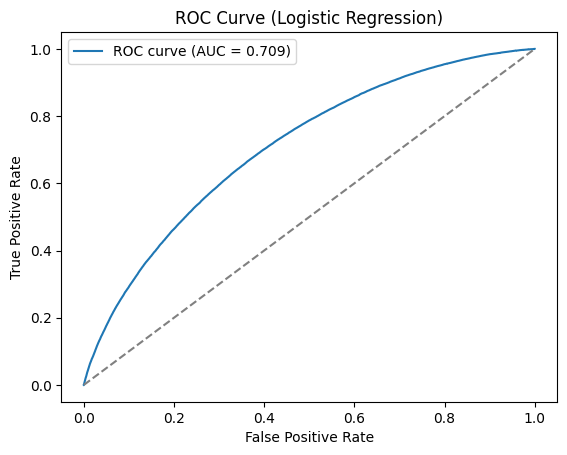

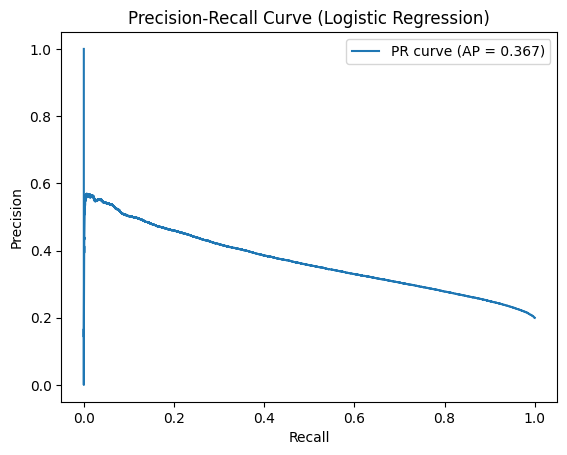

Best threshold (F1) for Logistic Regression: 0.50
Metrics @best threshold: {'roc_auc': 0.7085475004442794, 'pr_auc': 0.3673124615708887, 'f1': 0.4266663336912819, 'precision': 0.32081494695333773, 'recall': 0.6367634452685327, 'confusion_matrix': array([[142814,  72340],
       [ 19492,  34170]])}

Classification report (LogReg @best thr):
               precision    recall  f1-score   support

           0      0.880     0.664     0.757    215154
           1      0.321     0.637     0.427     53662

    accuracy                          0.658    268816
   macro avg      0.600     0.650     0.592    268816
weighted avg      0.768     0.658     0.691    268816



In [13]:
log_reg = LogisticRegression(
    solver='liblinear',  # robust for imbalanced binary + small-ish datasets per batch
    class_weight='balanced',
    max_iter=1000
)

log_reg.fit(X_train, y_train)

# Probabilities for the positive class (default = 1)
lr_proba_test = log_reg.predict_proba(X_test)[:, 1]

# Default threshold 0.5
lr_metrics_default = evaluate_at_threshold(y_test, lr_proba_test, threshold=0.5)
print("Logistic Regression @0.5:", lr_metrics_default)

# Curves
plot_roc_pr(y_test, lr_proba_test, title_suffix="(Logistic Regression)")

# Find a better threshold (maximize F1)
best_thr, best_score = find_best_threshold(y_test, lr_proba_test, metric="f1")
lr_metrics_best = evaluate_at_threshold(y_test, lr_proba_test, threshold=best_thr)
print(f"Best threshold (F1) for Logistic Regression: {best_thr:.2f}")
print("Metrics @best threshold:", lr_metrics_best)

# Show classification report at best threshold
y_pred_lr = (lr_proba_test >= best_thr).astype(int)
print("\nClassification report (LogReg @best thr):\n",
      classification_report(y_test, y_pred_lr, digits=3))


Step 4: Baseline — Random Forest (train and evaluate)

Tree model that handles non-linearities and interactions.

Uses class_weight='balanced_subsample' to reduce bias toward the majority class.

Again, we evaluate at 0.5 and then at the best F1 threshold.

Random Forest @0.5: {'roc_auc': 0.713120497228836, 'pr_auc': 0.37624792485563063, 'f1': 0.23754616447238588, 'precision': 0.48761574074074077, 'recall': 0.15701986508143564, 'confusion_matrix': array([[206300,   8854],
       [ 45236,   8426]])}


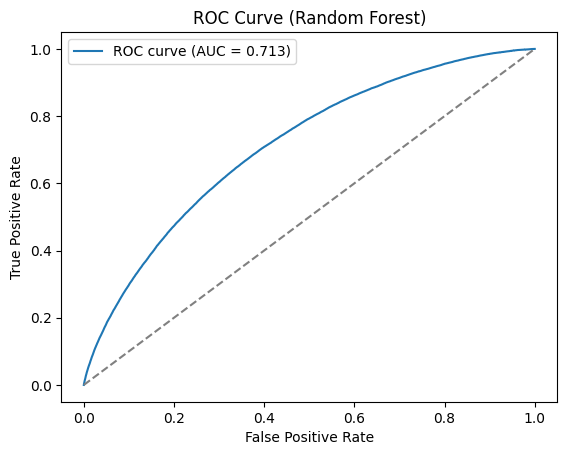

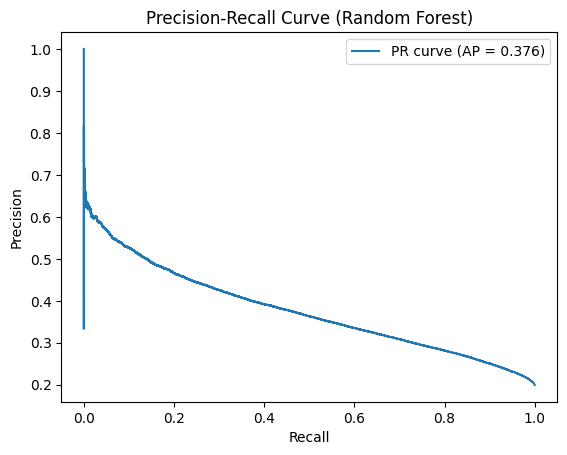

Best threshold (F1) for RF: 0.30
Metrics @best threshold: {'roc_auc': 0.713120497228836, 'pr_auc': 0.37624792485563063, 'f1': 0.42933196651289934, 'precision': 0.3389810388180827, 'recall': 0.5853490365621855, 'confusion_matrix': array([[153902,  61252],
       [ 22251,  31411]])}

Classification report (RF @best thr):
               precision    recall  f1-score   support

           0      0.874     0.715     0.787    215154
           1      0.339     0.585     0.429     53662

    accuracy                          0.689    268816
   macro avg      0.606     0.650     0.608    268816
weighted avg      0.767     0.689     0.715    268816



In [14]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced_subsample'
)

rf.fit(X_train, y_train)
rf_proba_test = rf.predict_proba(X_test)[:, 1]

rf_metrics_default = evaluate_at_threshold(y_test, rf_proba_test, threshold=0.5)
print("Random Forest @0.5:", rf_metrics_default)

plot_roc_pr(y_test, rf_proba_test, title_suffix="(Random Forest)")

best_thr_rf, best_score_rf = find_best_threshold(y_test, rf_proba_test, metric="f1")
rf_metrics_best = evaluate_at_threshold(y_test, rf_proba_test, threshold=best_thr_rf)
print(f"Best threshold (F1) for RF: {best_thr_rf:.2f}")
print("Metrics @best threshold:", rf_metrics_best)

y_pred_rf = (rf_proba_test >= best_thr_rf).astype(int)
print("\nClassification report (RF @best thr):\n",
      classification_report(y_test, y_pred_rf, digits=3))


Step 5: Tune the Better Model (RandomizedSearchCV - tune and evaluate)

We do a randomized search over sensible RF hyperparameters with stratified 3-fold CV, ranking by ROC-AUC. Then we evaluate on the test set and re-tune the threshold to maximize F1.

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best RF params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Best CV ROC-AUC: 0.7133743329218228


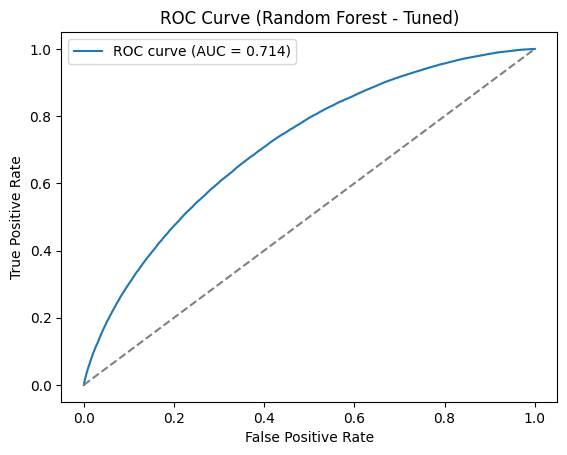

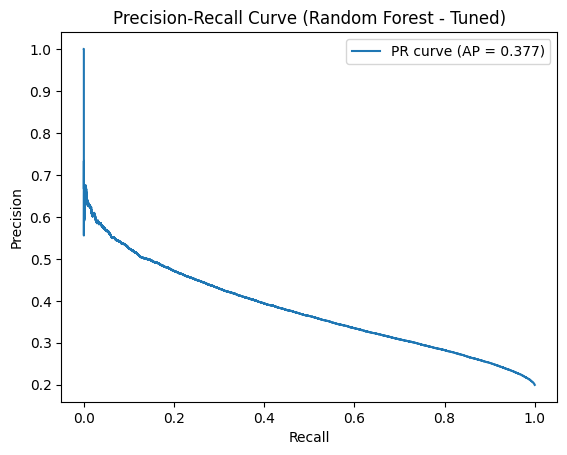

RF Tuned @best thr (0.25): {'roc_auc': 0.714168909640923, 'pr_auc': 0.37748066522722845, 'f1': 0.42875159101790117, 'precision': 0.3121875318845016, 'recall': 0.684227199880735, 'confusion_matrix': array([[134259,  80895],
       [ 16945,  36717]])}

Classification report (RF Tuned @best thr):
               precision    recall  f1-score   support

           0      0.888     0.624     0.733    215154
           1      0.312     0.684     0.429     53662

    accuracy                          0.636    268816
   macro avg      0.600     0.654     0.581    268816
weighted avg      0.773     0.636     0.672    268816



In [15]:
param_dist = {
    "n_estimators": [100, 200, 300],   # reduced for tuning
    "max_depth": [None, 10, 16],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"] 
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Base RF with subsampling for speed
rf_base = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    class_weight='balanced_subsample',
    bootstrap=True,
    max_samples=200_000  # Limit per tree → huge speedup
)

# Randomized search
rs = RandomizedSearchCV(
    rf_base,
    param_distributions=param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=cv,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    error_score='raise'
)

# Fit search
rs.fit(X_train, y_train)

print("Best RF params:", rs.best_params_)
print("Best CV ROC-AUC:", rs.best_score_)

# Evaluate tuned model on test set
rf_tuned = rs.best_estimator_
rf_tuned_proba = rf_tuned.predict_proba(X_test)[:, 1]

plot_roc_pr(y_test, rf_tuned_proba, title_suffix="(Random Forest - Tuned)")

best_thr_tuned, _ = find_best_threshold(y_test, rf_tuned_proba, metric="f1")
rf_tuned_metrics = evaluate_at_threshold(y_test, rf_tuned_proba, threshold=best_thr_tuned)
print(f"RF Tuned @best thr ({best_thr_tuned:.2f}):", rf_tuned_metrics)

y_pred_tuned = (rf_tuned_proba >= best_thr_tuned).astype(int)
print("\nClassification report (RF Tuned @best thr):\n",
      classification_report(y_test, y_pred_tuned, digits=3))

Load Features List

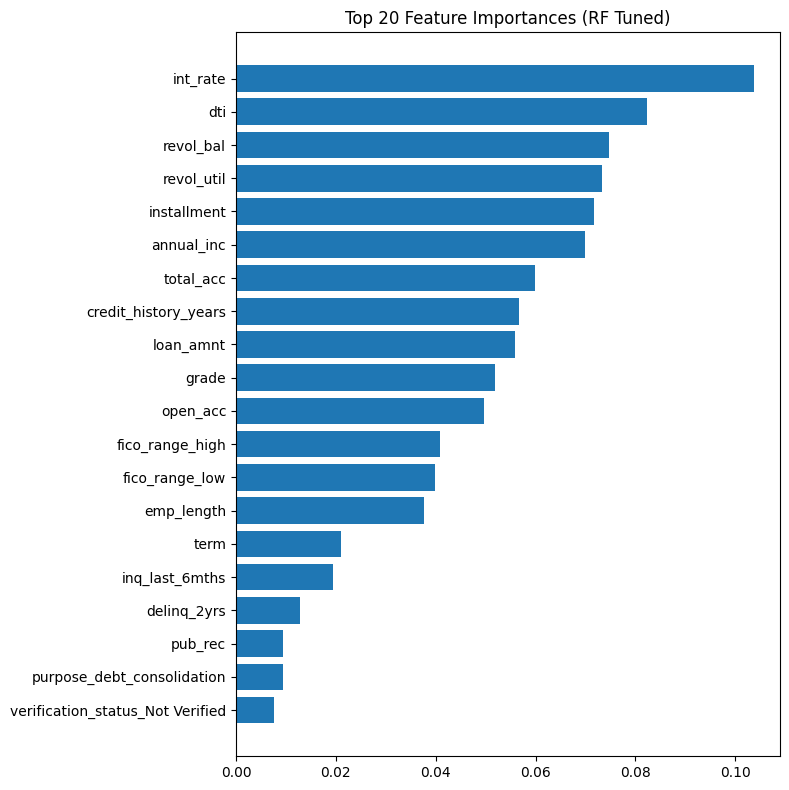

In [16]:
with open('../config/feature_info.json', 'r') as f:
    feat_info = json.load(f)
numeric_features = feat_info['numeric_features']
ordinal_features = feat_info['ordinal_features']
nominal_features = feat_info['nominal_features']
# ---------- Feature importance with readable names ----------
# Load feature lists (you already loaded them earlier)
# numeric_features, ordinal_features, nominal_features
# preprocessor already loaded from config in your first cell

def get_feature_names(preprocessor, num_cols, ord_cols, nom_cols):
    names = []
    # numeric names
    names += num_cols
    # ordinal names
    names += ord_cols
    # nominal expanded names
    ohe = preprocessor.named_transformers_['nom'].named_steps['onehot']
    ohe_names = ohe.get_feature_names_out(nom_cols).tolist()
    names += ohe_names
    return names

# Pick the model you want to inspect (rf_tuned is fine)
feature_names = get_feature_names(preprocessor, numeric_features, ordinal_features, nominal_features)

# RandomForest feature importances
importances = rf_tuned.feature_importances_
order = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 8))
plt.barh([feature_names[i] for i in order][::-1], importances[order][::-1])
plt.title("Top 20 Feature Importances (RF Tuned)")
plt.tight_layout()
plt.show()



Save the best model and threshold

In [18]:
import joblib, json, os
os.makedirs("../models", exist_ok=True)

joblib.dump(rf_tuned, "../models/best_model.joblib")

best_thr = float(best_thr_tuned)  # from your threshold search
with open("../models/threshold.json", "w") as f:
    json.dump({"threshold": best_thr}, f)

print("Saved best_model.joblib and threshold.json")


Saved best_model.joblib and threshold.json
